In [7]:
import gower
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN, OPTICS

import warnings
warnings.filterwarnings('ignore')

In [2]:
ls | grep .csv

predict.csv
training.csv


In [3]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
pred_df = pd.read_csv('predict.csv')
train_df.head()

id   posted_time  updated_time           age   updated_age app_type  \
0  175339  1.514050e+12  1.514050e+12  6.315242e+10  6.315242e+10    other   
1  175348  1.514110e+12  1.515160e+12  6.309278e+10  6.204696e+10    forum   
2  175353  1.514120e+12  1.515160e+12  6.309049e+10  6.204716e+10    forum   
3  175371  1.514190e+12  1.514190e+12  6.301324e+10  6.301324e+10    other   
4  175372  1.514190e+12  1.514190e+12  6.301323e+10  6.301323e+10    other   

   owner_id owner_type  owner_influence  number_of_likes  number_of_comments  \
0     57727      space          0.99973                1                   0   
1    111913      space          0.99977                0                   2   
2    111913      space          0.99977                0                   3   
3      9037      space          0.99949                0                   0   
4      9037      space          0.99949                0                   0   

   reactivity  is_mentions_me  is_mentions_connections  is_commented_by_me  \
0     1.00000               0                        0                   0   
1     0.12336               0                        0                   0   
2     0.12336               0                        0                   0   
3     0.00000               0                        0                   0   
4     0.00000               0                        0                   0   

   is_commented_by_connections  is_liked_by_me  is_liked_by_connections  \
0                            0               0                        1   
1                            1               0                        0   
2                            1               0                        0   
3                            0               0                        0   
4                            0               0                        0   

   poster_id poster_gender  poster_is_employee  poster_is_lead  \
0          5          male                   1               0   
1        146          male                   1               0   
2        146          male                   1               0   
3          7          male                   1               0   
4          7          male                   1               0   

   poster_is_in_connections poster_focus  poster_order  poster_influence  \
0                         1    marketing             6           0.99962   
1                         1    marketing             6           0.99899   
2                         1    marketing             6           0.99899   
3                         1    marketing             6           0.99886   
4                         1    marketing             6           0.99886   

   participant1_id participant1_action participant1_gender  \
0              146               liked                male   
1            13659           commented                male   
2            13659           commented                male   
3            22636              viewed                male   
4            22636              viewed                male   

   participant1_is_employee  participant1_is_lead  \
0                         1                     0   
1                         0                     0   
2                         0                     0   
3                         0                     0   
4                         0                     0   

   participant1_is_in_connections participant1_focus  participant1_order  \
0                               1          marketing                   5   
1                               0              other                   5   
2                               0              other                   5   
3                               1              other                   5   
4                               1              other                   5   

   participant1_influence  participant2_id participant2_action  \
0                 0.99899            22636              viewed   
1 

## Preprocessing

In [4]:
# Get rid of redundant columns
all_cols = [col for col in train_df.columns if col != 'rank']
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in all_cols if i not in redundant_cols]

train_df = train_df[useful_cols]

In [5]:
# Categorizing useful columns
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]
cat_vector = [col in cat_cols for col in all_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))
print("cat_vector: {}".format(cat_vector))

Amount of number columns: 22
Amount of categorical columns: 19
cat_vector: [True, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, False]


## DBSCAN

In [6]:
# Matrix of Gower distances.
d = gower.gower_matrix(data_x=train_df, cat_features=cat_vector)
print(d)

[[0.         0.2866772  0.30746377 ... 0.33050266 0.47931537 0.4079055 ]
 [0.2866772  0.         0.11834968 ... 0.5027714  0.56000686 0.4889303 ]
 [0.30746377 0.11834968 0.         ... 0.45814306 0.5155755  0.49294612]
 ...
 [0.33050266 0.5027714  0.45814306 ... 0.         0.25267905 0.12897126]
 [0.47931537 0.56000686 0.5155755  ... 0.25267905 0.         0.17299019]
 [0.4079055  0.4889303  0.49294612 ... 0.12897126 0.17299019 0.        ]]


In [71]:
dbscan = DBSCAN(eps=0.05, min_samples=3, metric='precomputed').fit(d)
dbscan.labels_

array([ 0,  1,  2, ..., -1, -1, -1])

In [72]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

## OPTICS

In [37]:
optics = OPTICS(min_samples=50, metric='precomputed').fit(d)
optics.labels_

array([ 0, -1,  6, ..., -1, -1, -1])

In [38]:
np.unique(optics.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Visualization

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [58]:
def prepare_tsne(n_components, data, labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    colors = plt.get_cmap('tab10').colors
    colors = plt.get_cmap('Set3').colors
    colors = plt.get_cmap('tab20b').colors
    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=colors[label],
               label=f"Cluster {label}", s=6, depthshade=True)
  
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('dbscan_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [59]:
# Creating dataframe for future visualization.

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

final_enc_df = train_df.copy()
final_enc_df = final_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
final_enc_df = final_enc_df.drop(cat_cols, axis=1)

In [60]:
final_enc_df['optics'] = optics.labels_

In [61]:
tsne_3d_df = prepare_tsne(3, train_enc_df, optics.labels_)

In [62]:
tsne_3d_df

x          y          z  labels
0      4.766263  -4.248677  21.588406       0
1     16.462208  -4.152340  14.711994      -1
2     21.226316  -8.690860  -7.752632       6
3     25.231659   9.610816  -9.067855      -1
4     24.901371   9.610625  -9.850230      -1
...         ...        ...        ...     ...
9413 -25.350925  -4.510343  -4.926985      -1
9414   3.220447   7.915054  -1.321332      -1
9415 -14.876569  11.344857   3.286204      -1
9416  -5.071094  15.838107  -4.377976      -1
9417  -7.190447  12.318983   4.667558      -1

[9418 rows x 4 columns]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

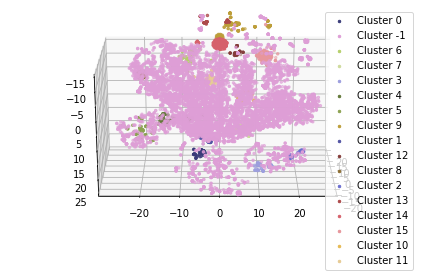

In [63]:
plot_animation(tsne_3d_df, 'labels', 'optics')

In [64]:
help(optics)

Help on OPTICS in module sklearn.cluster._optics object:

class OPTICS(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  OPTICS(min_samples=5, max_eps=inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None)
 |  
 |  Estimate clustering structure from vector array.
 |  
 |  OPTICS (Ordering Points To Identify the Clustering Structure), closely
 |  related to DBSCAN, finds core sample of high density and expands clusters
 |  from them [1]_. Unlike DBSCAN, keeps cluster hierarchy for a variable
 |  neighborhood radius. Better suited for usage on large datasets than the
 |  current sklearn implementation of DBSCAN.
 |  
 |  Clusters are then extracted using a DBSCAN-like method
 |  (cluster_method = 'dbscan') or an automatic
 |  technique proposed in [1]_ (cluster_method = 'xi').
 |  
 |  This implementation deviates from the original OPTICS by first p